# LGBM Model 

In [1]:
import pandas as pd 
import numpy as np 

## Setting Up the Data 

In [2]:
df = pd.read_csv('modeling_data.csv')
print(df.shape)
df.head()

(687, 17)


,TEAM_SEASON,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT,PO_WINS,TEAM_ID,TEAM_NAME
0,1610612737_2001-02,18.097566,0.461098,0.324734,0.163691,0.266759,0.476202,0.355158,0.153661,0.286407,80.000000,224.615385,3.153846,0.305,0.0,1610612737,Hawks
1,1610612737_2002-03,17.691622,0.459190,0.296291,0.165052,0.252703,0.490334,0.332949,0.151786,0.301969,79.187500,224.562500,4.125000,0.402,0.0,1610612737,Hawks
2,1610612737_2003-04,16.653165,0.467314,0.320842,0.167814,0.275845,0.480911,0.323210,0.142232,0.289654,80.133333,227.000000,4.000000,0.427,0.0,1610612737,Hawks
3,1610612737_2004-05,13.812289,0.432378,0.324171,0.166552,0.250593,0.494104,0.375538,0.167617,0.286726,79.769231,225.923077,5.076923,0.341,0.0,1610612737,Hawks
4,1610612737_2005-06,21.489895,0.463531,0.327702,0.170385,0.274347,0.510406,0.369320,0.144927,0.280918,78.846154,223.615385,1.923077,0.159,0.0,1610612737,Hawks


In [3]:
def modeling_data_setup(data,test_seasons,this_season,model_type):
    # returns x, xtest, y, ytest, this season's data 
    
    target = 'PO_WINS'
    
    import pandas as pd
    import numpy as np 
    
    if type(test_seasons) == int:
        test_seasons = [test_seasons]
    elif type(test_seasons) == list:
        test_seasons = test_seasons
    else:
        raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
        
    for i in test_seasons:
        if type(i)!=int:
            raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
    
    import pandas as pd
    import numpy as np 
    from sklearn.model_selection import train_test_split
    
    print('columns to drop:')
    drop_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','PO_WINS','SEASON']
    print(drop_cols)
    
    print('Creating SEASON for splitting')
    ids = data['TEAM_SEASON'].str.split('_')
    season = [int(x[1][0:4]) for x in ids]
    data['SEASON'] = season
    
    print("Dropping this season: {}".format(this_season))
    current = data[data['SEASON']==this_season].copy()
    
    print('Dropping the Pelicans and Hornets first season')
    data = data[~data['LS_WIN_PCT'].isna()].copy()
    
    test = data[data['SEASON'].isin(test_seasons)].copy()
    train = data[(~data['SEASON'].isin(test_seasons))&(data['SEASON']!=this_season)].copy()
    ytest = test[target].copy()
    ytrain = train[target].copy()
    xtest = test.drop(drop_cols,axis=1)
    xtrain = train.drop(drop_cols,axis=1)
    
    print("Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season")
    
    return train,test,xtrain,xtest,ytrain,ytest,current

In [4]:
train, test, x_train, x_test, y_train, y_test, upcoming = modeling_data_setup(df,[2022],2023,'reg')

columns to drop:
['TEAM_SEASON', 'TEAM_ID', 'TEAM_NAME', 'PO_WINS', 'SEASON']
Creating SEASON for splitting
Dropping this season: 2023
Dropping the Pelicans and Hornets first season
Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season


In [5]:
id_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','SEASON']
train_ids = train[id_cols].copy()
test_ids = test[id_cols].copy()

## Modeling

In [6]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature reduction 
from sklearn import feature_selection
from sklearn import pipeline

# for the modeling
from lightgbm import LGBMClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# from sklearn.externals import joblib
import time
import numpy as np

# getting rid of the warnings 
import warnings
warnings.filterwarnings('ignore')

def running_time(start):
    print('running time is', (time.time() - start)/60, 'mins')

In [7]:
start = time.time()

rds_params = {
'boosting_type': ['goss'],
'n_estimators':[1600, 1800, 2000],
'max_depth': [4,5,6],
'subsample': [0.3, 0.4, 0.5, 0.6],
'num_leaves': [15,30, 45 ],
'subsample_for_bin': [5000,10000,20000],  #Change the subsample for bin 5000, 10,000, 20000
'colsample_bytree':[0.6,0.7,0.8],
'min_child_samples': [10,15,20],
'min_child_weight': [12, 14, 16],
'lambda_l1': [2,4,5],
'learning_rate': [0.001,0.01, 0.02,0.03],
'lambda_l2': [12, 14,15],
}

model = LGBMClassifier(n_jobs = -1)

clf = RandomizedSearchCV(model, rds_params, cv=3,  n_iter=70, verbose=1,scoring = 'neg_root_mean_squared_error',return_train_score = True)
clf.fit(x_train,y_train)

running_time(start)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is s

In [8]:
cv = pd.DataFrame( clf.cv_results_)

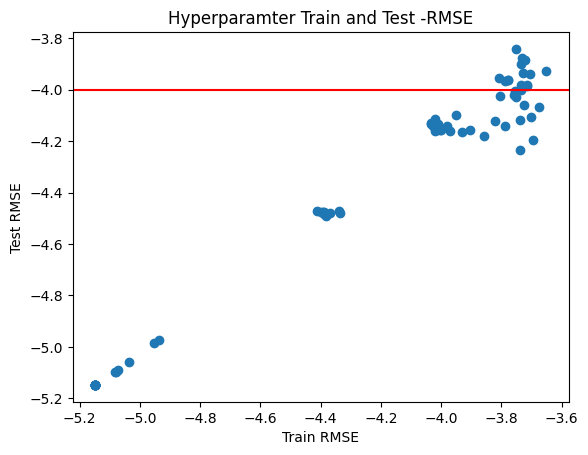

In [9]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv['mean_train_score'],cv['mean_test_score'] )
plt.axhline(-4, color='r', linestyle='-')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.3,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [10]:
cv[cv['mean_test_score']>-4]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample_for_bin,param_subsample,param_num_leaves,param_n_estimators,param_min_child_weight,param_min_child_samples,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,10.552987,0.620790,0.014708,0.009363,20000,0.6,30,1600,14,15,...,-3.797140,-4.147520,-3.984739,0.144115,14,-3.587170,-3.865546,-3.688078,-3.713598,0.115070
5,12.685098,0.816263,0.019104,0.009600,20000,0.6,15,1800,12,10,...,-3.770457,-3.879805,-3.883221,0.093498,3,-3.638073,-3.781819,-3.744540,-3.721478,0.060908
11,12.172077,0.317188,0.019744,0.007806,5000,0.5,30,1600,14,20,...,-3.785727,-3.848076,-3.877137,0.088907,2,-3.640055,-3.860890,-3.691977,-3.730974,0.094278
18,15.024047,0.791348,0.021470,0.005065,20000,0.6,45,1800,12,15,...,-3.753844,-3.990975,-3.933550,0.129800,6,-3.576096,-3.845643,-3.763067,-3.728268,0.112760
28,11.775850,1.942042,0.008525,0.000039,5000,0.3,30,1600,14,15,...,-3.808518,-3.810411,-3.841708,0.045607,1,-3.675543,-3.868337,-3.707533,-3.750471,0.084361
33,16.031240,2.572911,0.011463,0.002990,20000,0.6,15,1800,14,10,...,-3.722334,-3.924161,-3.899201,0.135377,4,-3.635429,-3.836590,-3.734601,-3.735540,0.082126
34,13.574387,1.617533,0.020739,0.010946,5000,0.5,15,1600,14,20,...,-3.812303,-4.059651,-3.982792,0.120749,12,-3.708747,-3.770388,-3.727852,-3.735663,0.025764
36,12.851800,1.501961,0.014098,0.007727,20000,0.5,15,1600,14,20,...,-3.978911,-3.892794,-3.983296,0.075748,13,-3.610881,-3.832838,-3.697494,-3.713738,0.091339
37,12.345927,1.265176,0.008748,0.000081,10000,0.5,30,1600,12,10,...,-3.632122,-3.971049,-3.965606,0.270094,11,-3.759283,-3.853741,-3.752857,-3.788627,0.046117
38,11.384240,0.662611,0.012587,0.005515,10000,0.5,15,1600,14,15,...,-3.732008,-4.001802,-3.928897,0.140774,5,-3.590519,-3.774202,-3.586546,-3.650422,0.087541


## Evaluation

In [11]:
import sklearn

### Train 

In [12]:
predictions = clf.predict(x_train)

In [13]:
mse = sklearn.metrics.mean_squared_error(y_train,predictions)
mae = sklearn.metrics.mean_absolute_error(y_train,predictions)
r2 = sklearn.metrics.r2_score(y_train,predictions)
rmse = np.sqrt(mse)

In [14]:
train_output = pd.DataFrame({'Actual':y_train,'Prediction':predictions})
train_output['Team'] = train['TEAM_NAME']
train_output['Season'] = train['SEASON']
train_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
train_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
train_results = train_results.transpose().reset_index(drop=True)
train_results.columns = train_results.iloc[0,:]
train_results = train_results.tail(1)

In [15]:
train_output.head()

,Actual,Prediction,Team,Season
0,0.0,0.0,Hawks,2001
46,0.0,0.0,Cavaliers,2001
91,0.0,0.0,Bulls,2001
137,0.0,0.0,Nuggets,2001
160,0.0,0.0,Warriors,2001


In [16]:
train_results

,MSE,MAE,R2,RMSE
1,26.9952,3.3632,-0.445363,5.195691


### Test 

In [17]:
predictions = clf.predict(x_test)

In [18]:
mse = sklearn.metrics.mean_squared_error(y_test,predictions)
mae = sklearn.metrics.mean_absolute_error(y_test,predictions)
r2 = sklearn.metrics.r2_score(y_test,predictions)
rmse = np.sqrt(mse)

In [19]:
test_output = pd.DataFrame({'Actual':y_test,'Prediction':predictions})
test_output['Team'] = test['TEAM_NAME']
test_output['Season'] = test['SEASON']
test_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
test_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
test_results = test_results.transpose().reset_index(drop=True)
test_results.columns = test_results.iloc[0,:]
test_results = test_results.tail(1)

In [20]:
test_output.head()

,Actual,Prediction,Team,Season
21,2.0,0.0,Hawks,2022
89,0.0,0.0,Pelicans,2022
204,0.0,0.0,Rockets,2022
227,1.0,0.0,Clippers,2022
250,8.0,0.0,Lakers,2022


In [21]:
test_results

,MSE,MAE,R2,RMSE
1,21.733333,3.466667,-0.17945,4.661902


### Upcoming Season 

In [22]:
x_up = upcoming[clf.best_estimator_.feature_name_]
x_up.head()

,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT
22,18.016026,0.545016,0.266234,0.138654,0.244933,0.546807,0.273492,0.132161,0.228750,74.210526,212.500000,4.210526,0.500
45,17.141471,0.574906,0.245406,0.154088,0.205274,0.551555,0.261706,0.134655,0.210411,79.235294,221.470588,5.352941,0.695
68,18.456579,0.533045,0.246079,0.154702,0.218635,0.528808,0.282211,0.151173,0.226084,77.894737,211.263158,5.000000,0.622
90,19.033183,0.531229,0.300521,0.136806,0.241501,0.540870,0.260355,0.134875,0.219382,78.500000,215.875000,4.375000,0.512
113,20.332340,0.553620,0.264355,0.128804,0.215955,0.533605,0.257386,0.150217,0.204654,78.000000,214.150000,4.650000,0.488


In [23]:
predictions = clf.predict(x_up)
final_output = x_up.copy() 
final_output['Predicted Wins'] = predictions
final_output['Predicted Wins (Rounded)'] = [round(x) for x in predictions]
final_output['Team'] = upcoming['TEAM_NAME']
def rounds(x):
    if x < 4:
        return 'R1/Lottery'
    elif 4<=x<8:
        return 'Second Round'
    elif 8<=x<12: 
        return 'Conf. Finals'
    elif 12<=x<16:
        return 'Finals'
    elif x>=16:
        return 'Champions'
final_output['Round'] = [rounds(x) for x in final_output['Predicted Wins']]
final_output.sort_values('Predicted Wins',inplace=True)
fo = final_output[['Team','Predicted Wins','Predicted Wins (Rounded)','Round']]
fo

,Team,Predicted Wins,Predicted Wins (Rounded),Round
343,Nets,0.0,0,R1/Lottery
642,Wizards,0.0,0,R1/Lottery
596,Jazz,0.0,0,R1/Lottery
550,Thunder,0.0,0,R1/Lottery
527,Spurs,0.0,0,R1/Lottery
481,Trail Blazers,0.0,0,R1/Lottery
412,Pacers,0.0,0,R1/Lottery
389,Magic,0.0,0,R1/Lottery
665,Pistons,0.0,0,R1/Lottery
686,Hornets,0.0,0,R1/Lottery


In [24]:
len(list(final_output['Team']))

30

In [25]:
ec_teams = ['Hornets',
 'Wizards',
 'Hawks',
 'Pacers',
 'Magic',
 'Pistons',
 'Raptors',
 'Knicks',
 'Bulls',
 'Cavaliers',
 'Nets',
 '76ers',
 'Heat',
 'Celtics',
 'Bucks']
wc_teams = ['Thunder',
 'Rockets',
 'Spurs',
 'Trail Blazers',
 'Kings',
 'Pelicans',
 'Grizzlies',
 'Timberwolves',
 'Jazz',
 'Warriors',
 'Mavericks',
 'Lakers',
 'Clippers',
 'Suns',
 'Nuggets']

In [26]:
ec = fo[fo['Team'].isin(ec_teams)]
wc = fo[fo['Team'].isin(wc_teams)]

In [27]:
print("Bet to Win EC: ")
ecb = ec.sort_values('Predicted Wins').tail(4)
ecb

Bet to Win EC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
297,Bucks,7.0,7,Second Round
274,Heat,7.0,7,Second Round
22,Hawks,7.0,7,Second Round
68,Cavaliers,16.0,16,Champions


In [28]:
print("Bet to Win WC: ")
wcb = wc.sort_values('Predicted Wins').tail(4)
wcb

Bet to Win WC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
159,Nuggets,7.0,7,Second Round
182,Warriors,7.0,7,Second Round
320,Timberwolves,7.0,7,Second Round
228,Clippers,7.0,7,Second Round


In [29]:
print("Bet to Win NBA Finals: ")
fob = fo.sort_values('Predicted Wins').tail(4)
fob

Bet to Win NBA Finals: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
22,Hawks,7.0,7,Second Round
251,Lakers,7.0,7,Second Round
435,76ers,7.0,7,Second Round
68,Cavaliers,16.0,16,Champions


## Writing Info 

In [30]:
train_output['SUBSET'] = 'TRAIN'
test_output['SUBSET'] = 'TEST'
total_output = pd.concat([train_output,test_output])

In [31]:
train_results['SUBSET'] = 'TRAIN'
test_results['SUBSET'] = 'TEST'
total_results = pd.concat([train_results,test_results])
total_results

,MSE,MAE,R2,RMSE,SUBSET
1,26.9952,3.3632,-0.445363,5.195691,TRAIN
1,21.733333,3.466667,-0.17945,4.661902,TEST


In [33]:
model_name = input()

lgbm_20230808


In [34]:
initial_path = ''
cv_path = initial_path+model_name+'_cv_results.csv'
output_path = initial_path+model_name+'_output.csv'
results_path = initial_path+model_name+'_results.csv'
predictions_path = initial_path+model_name+'_full_predictions.csv'
ec_path = initial_path+model_name+'_ecf_predictions.csv'
wc_path = initial_path+model_name+'_wcf_predictions.csv'
f_path = initial_path+model_name+'_finals_predictions.csv'
print(cv_path)
print(output_path)
print(results_path)
print(predictions_path)
print(ec_path)
print(wc_path)
print(f_path)

lgbm_20230808_cv_results.csv
lgbm_20230808_output.csv
lgbm_20230808_results.csv
lgbm_20230808_full_predictions.csv
lgbm_20230808_ecf_predictions.csv
lgbm_20230808_wcf_predictions.csv
lgbm_20230808_finals_predictions.csv


In [35]:
cv.to_csv(cv_path,index=False)
total_output.to_csv(output_path,index=False)
total_results.to_csv(results_path,index=False)
fo.to_csv(predictions_path,index=False)
ecb.to_csv(ec_path,index=False)
wcb.to_csv(wc_path,index=False)
fob.to_csv(f_path,index=False)

In [36]:
import pickle

# save the model to disk
filename = model_name+'.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## What if I had Used this Model Last Year? 

In [37]:
ec2 = test_output[test_output['Team'].isin(ec_teams)]
wc2 = test_output[test_output['Team'].isin(wc_teams)]

In [38]:
print("Bet to Win EC: ")
ecb2 = ec2.sort_values('Prediction').tail(4)
ecb2

Bet to Win EC: 


,Actual,Prediction,Team,Season,SUBSET
434,7.0,7.0,76ers,2022,TEST
572,0.0,7.0,Raptors,2022,TEST
273,13.0,10.0,Heat,2022,TEST
44,11.0,16.0,Celtics,2022,TEST


In [39]:
print("Bet to Win WC: ")
wcb2 = wc2.sort_values('Prediction').tail(4)
wcb2

Bet to Win WC: 


,Actual,Prediction,Team,Season,SUBSET
457,6.0,7.0,Suns,2022,TEST
595,0.0,7.0,Jazz,2022,TEST
158,16.0,10.0,Nuggets,2022,TEST
618,2.0,10.0,Grizzlies,2022,TEST


In [40]:
print("Bet to Win NBA Finals: ")
fob2 = test_output.sort_values('Prediction').tail(4)
fob2

Bet to Win NBA Finals: 


,Actual,Prediction,Team,Season,SUBSET
618,2.0,10.0,Grizzlies,2022,TEST
158,16.0,10.0,Nuggets,2022,TEST
273,13.0,10.0,Heat,2022,TEST
44,11.0,16.0,Celtics,2022,TEST
